# Inspect-study_v2.ipynb

This notebook enables some simple visualization of the data contained in a given datasheet within the vgp database.

In [1]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from scipy import optimize
import seaborn as sns

from scripts.auxiliar import (get_files_in_directory, spherical2cartesian, cartesian2spherical, GCD_cartesian, 
                              print_pole_statistics, test_fishqq, reversal_test, invert_polarity, Plot_VgpsAndSites,
                              bayes_probability_heslop, bayes_support)
pd.set_option('display.max_columns', None)

### Displaying all the .xlsx files in the vgp_database folder

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/vgp_database'
files_names = get_files_in_directory(data_path_VGP)

csv_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.csv')] #consider just *csv files
xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')] #consider just *csv files
paths = [file for file in files_names if file.endswith('.xlsx')] 
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})
df_files[['name_xlsx']]

name_xlsx
0                    Absaroka_volcanics
1               Beaver_River_intrusions
2               Bighorn_Basin_sediments
3                           Bishop_tuff
4            Bitterroot_Dome_intrusions
5       Central_Mexico_Plio-Pleistocene
6             Clear_Lake_volcanic_field
7                  Coso_Range_volcanics
8                       Dinan_Bay_lavas
9             Eastern_Alkaline_Province
10                         Eastern_TMVB
11            East_Fork_Basin_sediments
12                 Latir_volcanic_field
13        Long_Valley_Caldera_volcanics
14              Mariscal_Mtn_intrusions
15  Michoacan_Guanajuato_volcanic_field
16                Mistastin_Lake_impact
17             Mogollon-Datil_volcanics
18                  Monterey_intrusions
19                 N_Montana_intrusions
20                  Ramsay_Island_lavas
21          Rattlesnake_Hills_volcanics
22       Robinson_Antincline_intrusions
23             San_Luis_Hills_volcanics
24                 Sierra_de_Las_Cruces
25                    Snake_River_Plain
26                     Sonoma_volcanics
27                     Stanislaus_Group
28          Stoddard_Mountain_laccolith
29                     SW_USA_composite
30               Tequila_volcanic_field
31             Valles_Caldera_volcanics
32             Washakie_Basin_sediments
33                 Western_Central_TMVB

### Select by index the file you want to display

In [3]:
index = 0

#### Separate the *.xlsx file into two different DFs, `df_vgps` and `df_poles`. 
Note: the the number of lines to be skip is harcoded

In [4]:
df = pd.read_excel(df_files['path'][index]) #, skip_blank_lines=True
df_poles = pd.read_excel(df_files['path'][index], 
                         skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,
                         nrows  = df[df.isnull().all(1)].index[1] -3)

df_vgps = pd.read_excel(df_files['path'][index], 
                        skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)

#cast columns
df_vgps = df_vgps.astype({'in_study_pole': int,
                          "slat":float, "slon":float, "dec":float, "inc":float,
                          "VGP_lat":float, "VGP_lon":float
                         })
df_poles = df_poles.astype({'N': int,
                          "slat":float, "slon":float, "dec":float, "inc":float,
                          "Plat":float, "Plon":float})

## We then proceed to populate the VGP DataFrame (`df_vgps`) following different criteria
 1. In a previous step, we have calculated the site coordinates of all studies in which these coordinates were not reported, but the Dec/Inc and Plat/Plon were. 
 1. When VGP coordinates are reported in the original manuscript (`df_vgps['VGP_lat']` and `df_vgps['VGP_lon']`), we take them as face value 

In [5]:
# redundant, but plain to see.
df_vgps['VGP_lon'] = df_vgps['VGP_lon']
df_vgps['VGP_lat'] = df_vgps['VGP_lat']

 2. When VGP coordinates are NOT reported in the original manuscript but the dec/inc and location of the sites was, we calculate them, and take them as face value.

In [6]:
df_vgps['VGP_lon'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0] if (np.isnan(row.VGP_lon) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lon, axis =1) 
df_vgps['VGP_lat'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1] if (np.isnan(row.VGP_lat) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lat, axis =1) 

## Check polarity of VGPs against directions
 3. Some sites report the backward VGP (so that the VGPs are in the same hemisphere/closer to the principal component). We proceed to check polarity of VGPs against directions. To do that, we recalculate the vgps from the original Dec/Inc.

In [7]:
#First we calculate for the entire dataframe the vgps if there is dec/inc and slat/slon values
df_vgps['VGP_lon_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1) 
df_vgps['VGP_lat_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)

 4. Check distance (`df_vgps['GCD_vgps']`) between the reported VGPs and the recalculated from the directions.

In this step we fill the column `df_vgps['coherent_vgps']` with the following 
- False if inconsistent combination of site coordinates + dec/inc + vgp data (+- 2 degrees away from the reported or its backward)
- True if correct
- np.nan if inverted

In [8]:
df_vgps['GCD_vgps'] = df_vgps.apply(lambda row: GCD_cartesian(spherical2cartesian([np.radians(row.VGP_lat), np.radians(row.VGP_lon)]), spherical2cartesian([np.radians(row.VGP_lat_recalc), np.radians(row.VGP_lon_recalc)])), axis=1)

# False if Spurious, True if correct, nan if inverted
df_vgps['coherent_vgps'] = df_vgps.apply(lambda row: 'spurious' if (row.GCD_vgps > np.radians(4) and row.GCD_vgps < np.radians(176)) else ('coherent' if row.GCD_vgps < np.radians(4) else 'inverted' if row.GCD_vgps > np.radians(176) else np.nan ), axis =1) #True if it is ok, nan 

### Catch some exceptions:
 - Missing slat/slon and/or dec/in where no vgp is reported
 - Missing dec/inc and/or vgp where no site coordinates are reported; cannot calculate site locations.
 - Inconsistent combination of site coordinates + dec/inc + vgp
 - Recalculated VGP was inverted. 

In [9]:
if not df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) &
               (df_vgps['dec'].isna() | df_vgps['inc'].isna()) &
               (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:
                  
# if (((df_vgps['slat'].isna() | df_vgps['slon'].isna()) & (df_vgps['dec'].isna() | df_vgps['inc'].isna())).any()):
#     index = df_vgps['slat'].index[df_vgps['slat'].apply(np.isnan)]
    print (f" => Missing slat/slon and/or dec/inc from sites ('name'): {df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) & (df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].name.tolist()} where no vgp is reported; cannot calculate vgp")
    print (f"")
    
if not df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) &
               (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:
    
#if (((df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())).any()):
    print(f" => Missing dec/inc and/or vgp in sites: {df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].name.tolist()} where no site coordinates are reported; cannot calculate site locations")
    print (f"")
    
if not df_vgps[df_vgps['coherent_vgps'] == 'spurious'].empty:
    print (f" => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) {df_vgps[df_vgps['coherent_vgps'] == 'spurious'].name.tolist()}")
    print (f"")
# spourious = df_vgps[df_vgps['coherent_vgps'] == False]['name'].unique()
# if len(spourious) != 0: 

if not df_vgps[df_vgps['coherent_vgps'] == 'inverted'].empty:
    print (f" => inverted vgp from sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'inverted'].name.tolist()}")
    print (f"")
    
if not df_vgps[df_vgps['coherent_vgps'] == 'coherent'].empty:
    print (f" => Coherent dec/inc in sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'coherent'].name.tolist()}")
    print (f"")

 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) [620.0, 622.0, 617.0, 625.0, 'I8']

 => inverted vgp from sites ('name'): [389.0, 390.0, 394.0, 396.0, 624.0, 'I1', 'I2', 'I3', 'I4', 'I6', 'I7', 'I5']

 => Coherent dec/inc in sites ('name'): [615.0, 395.0, 'AS1', 'AS2', 'AS3', 'AS4', 618.0, 558.0, 557.0, 448.0, 621.0, 628.0, 635.0, 627.0, 616.0, 'HY-1', 923.0]



### Now, for each reported pole from the selected manuscript we iterate through the constituent site-level data and: 
1) cast all vgps into a common polarity and re-compute the Fisher mean
2) plot the site locations, vgps, and the results of reversal and Fisher distribution tests

==>Analizing pole 1 (Absaroka_volcanics).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        19       83.5     177.4    10.1
Recomputed paleopole   1.0        19       83.3     177.4    11.1



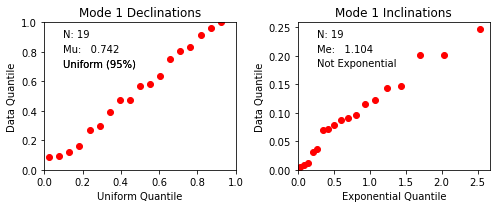

 
 - Only one polarity; cannot conduct Bootstrapped reversal test
Single Polarity, cannot conduct Bayesian Reversal Test


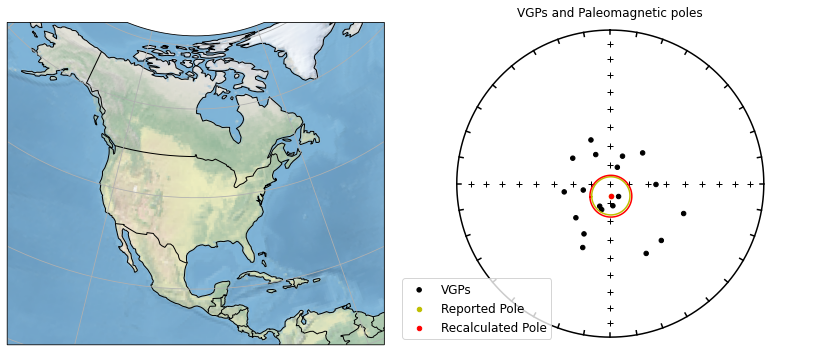

==>Analizing pole 2 (Absaroka_volcanics).
 DEBUG POLE (index): 0, in_situ_pole: 2
==>Analizing pole 3 (Absaroka_volcanics).
                       Pole       N        Plat      Plon     A95
Reported paleopole     3.0        22       80.8     145.9     8.6
Recomputed paleopole   3.0        22       80.8     145.9     8.6



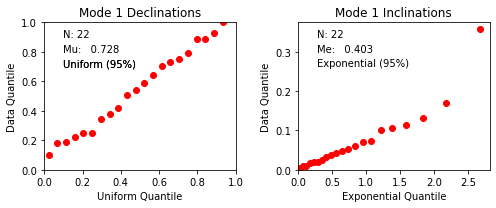

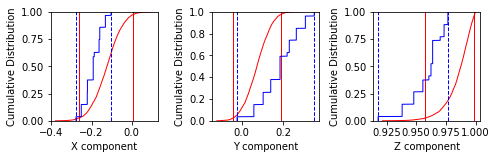

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


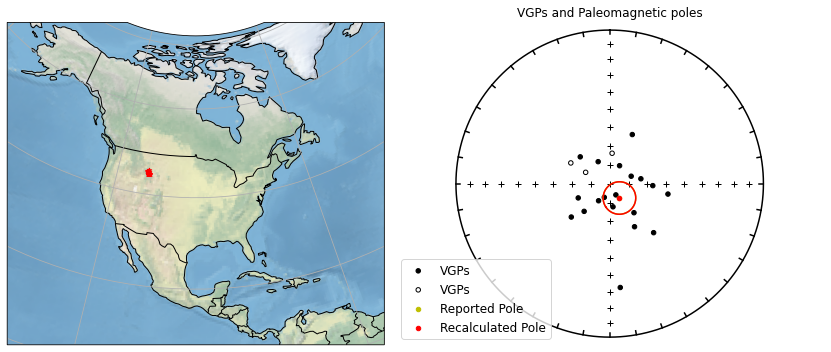

In [10]:
#Groupby iterates through DFs (i) 'grouped by' the variable of interest 
for value, i in df_vgps.groupby(df_vgps['in_study_pole']): 
    # value represent the index and i represent the DF grouped by the variable of interest  
    if value != 0: #discards vgps discarded by authors
               
        print(f"==>Analizing pole {value} ({df_files.name_xlsx[index]}).")
        try:
                   
            # Pick those sites where the reported vgps were inverted in order to perform a Reversal test
            df_tmp = pd.DataFrame()            
            df_tmp['vgp_lat4reversal'] = np.where(((i['coherent_vgps'] == 'inverted') & 
                                                   (~i['coherent_vgps'].isna())), 
                                                    i['VGP_lat_recalc'], i['VGP_lat'])            
            df_tmp['vgp_lon4reversal'] = np.where(((i['coherent_vgps'] == 'inverted') & 
                                                   (~i['coherent_vgps'].isna())), 
                                                    i['VGP_lon_recalc'], i['VGP_lon'])
            
            #split vgp population into different polarities by comparison against principal component axis             
            vgp_block = list(zip(df_tmp['vgp_lon4reversal'].tolist(), df_tmp['vgp_lat4reversal'].tolist()))            
            mode1, mode2 = pmag.separate_directions(di_block=vgp_block)
            
            #invert one polarity population and merge populations
            merged = invert_polarity(mode1, mode2)

            #calculate Fisher mean of merged data
            vgp_mean = ipmag.fisher_mean(di_block=merged)

            #Reported pole
            pole = df_poles[df_poles['pole'] == value]

            print_pole_statistics(pole, vgp_mean)

            # Test whether a distribution is Fisherian
            test_fishqq(merged)

            #reversal test            
            reversal_test(mode1, mode2)
            
            #Bayesian reversal Test
            P = bayes_probability_heslop(mode1, mode2)
            if P != 9999: print(f"Bayesian reversal test (Heslop & Roberts, 2018) indicates: {bayes_support(P)}")
            
            # Plot sites and directions
            Plot_VgpsAndSites(i, pole, vgp_mean, mode1, mode2)            
            
        except: #could be expanded!
            print(f" DEBUG POLE (index): {index}, in_situ_pole: {value}")

# Iterate through all the files to catch exceptions:


========================= NEW POLE : Absaroka_volcanics (0) =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) [620.0, 622.0, 617.0, 625.0, 'I8']

 => inverted vgp from sites ('name'): [389.0, 390.0, 394.0, 396.0, 624.0, 'I1', 'I2', 'I3', 'I4', 'I6', 'I7', 'I5']

 => Coherent dec/inc in sites ('name'): [615.0, 395.0, 'AS1', 'AS2', 'AS3', 'AS4', 618.0, 558.0, 557.0, 448.0, 621.0, 628.0, 635.0, 627.0, 616.0, 'HY-1', 923.0]

==>Analizing pole 1 (Absaroka_volcanics).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        19       83.5     177.4    10.1
Recomputed paleopole   1.0        19       83.3     177.4    11.1



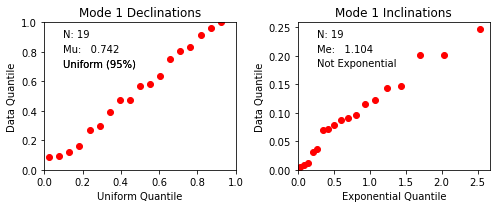

 
 - Only one polarity; cannot conduct Bootstrapped reversal test
Single Polarity, cannot conduct Bayesian Reversal Test


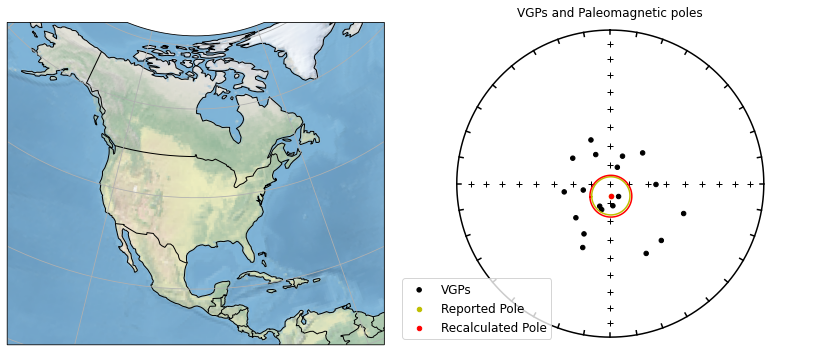

==>Analizing pole 2 (Absaroka_volcanics).
 DEBUG POLE (index): 0, in_situ_pole: 2
==>Analizing pole 3 (Absaroka_volcanics).
                       Pole       N        Plat      Plon     A95
Reported paleopole     3.0        22       80.8     145.9     8.6
Recomputed paleopole   3.0        22       80.8     145.9     8.6



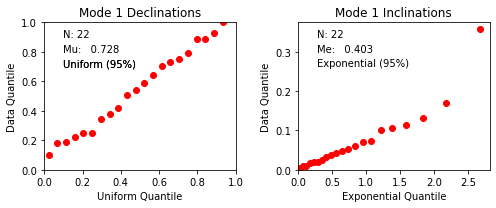

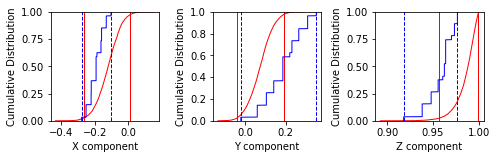

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


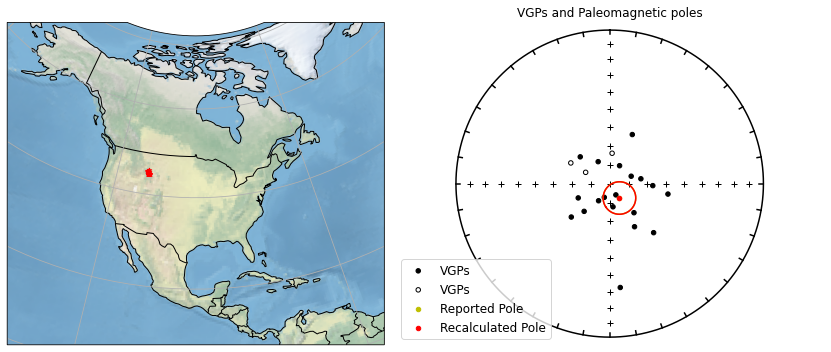


========================= NEW POLE : Beaver_River_intrusions (1) =======================
 => Coherent dec/inc in sites ('name'): ['01 LCE', '02 LCE', '03 LCE', '04 LCE', '05 LCE', '06 LCE', '07 LCE', '08 LCE', '09 LCW*', '10 LCW', '11 LCW', '12 LCW', '13 LCW*', '14 LCW', '16 LCW', '17 LCW*', '18 BR', '19 BR', '20 BR', '21 BR', '22 BR', '23 BR', '24 BR', '25 BR*', '26 BR']

==>Analizing pole 1 (Beaver_River_intrusions).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        21       79.2     145.8     nan
Recomputed paleopole   1.0        21       79.3     147.7     4.8



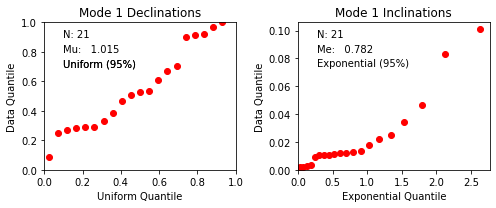

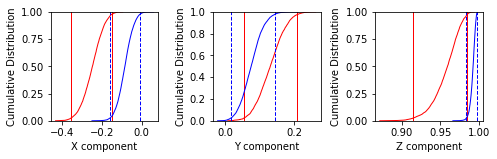

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


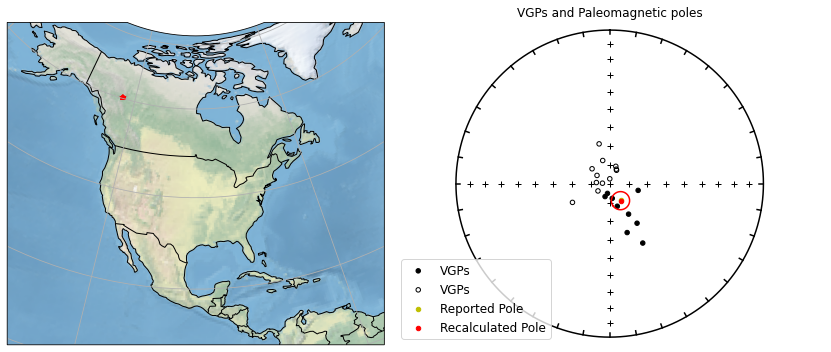


========================= NEW POLE : Bighorn_Basin_sediments (2) =======================
 => Coherent dec/inc in sites ('name'): ['BH0414β', 'BH0401α', 'BH0403α', 'BH0404α', 'BH0405α', 'BH0407α', 'BH0408α', 'BH0410α', 'BH0412β', 'BH02015α', 'BH02016β', 'BH02019β', 'BH02018β', 'BH02020β', 'BH02021β', 'BH0415α', 'BH0416α', 'BH0417α', 'BH0418β', 'BH0419α', 'BH0420α', 'BH0421α', 'BH0422α', 'BH02034α', 'BH02035α', 'BH02037α', 'BH02038α', 'BH02039α', 'BH02040α', 'BH02041α', 'BH02042α', 'BH02043α', 'BH02044α', 'BH0423α', 'BH0424α', 'BH0425α', 'BH0426a', 'BH0427β', 'BH0433β', 'BH01025α', 'BH01027α', 'BH01028α', 'BH01031α', 'BH01033β', 'BH01036β', 'BH01037β', 'BH01038α', 'BH01039α', 'BH01040α', 'BH01041β', 'BH01042β', 'BH01043α', 'BH01045α', 'BH01046α', 'BH01049α', 'BH01050α', 'BH01051α', 'BH01052β', 'BH01053α', 'BH01054β', 'BH01055α', 'BH01056β', 'BH01057β', 'BH01061β', 'BH01064α', 'BH01066β', 'BH01068β', 'BH01071β', 'BH01073α', 'BH01075β', 'BH01076α', 'BH01077α', 'BH01079β', 'BH01080α', 'BH0

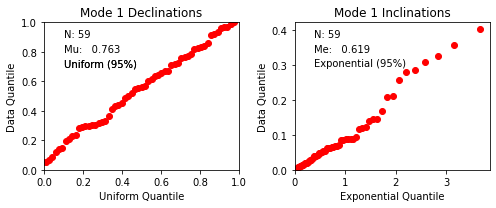

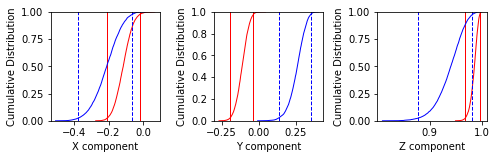

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Different means: very strong support


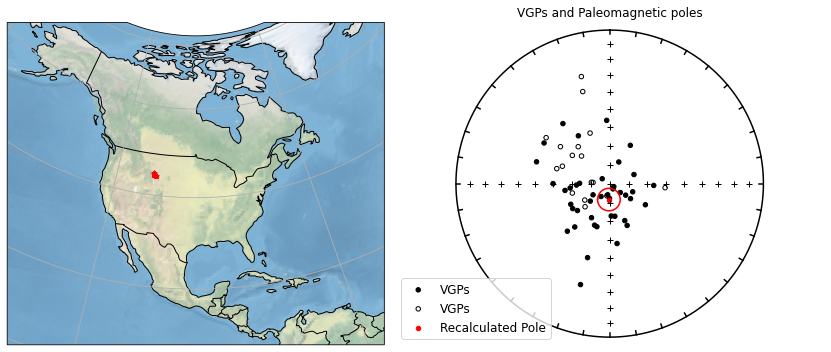


========================= NEW POLE : Bishop_tuff (3) =======================
 => Coherent dec/inc in sites ('name'): ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B23', 'B24', 'B25 (0 m)', 'B25 (3 m)', 'B25 (6 m)', 'B25 (9 m)', 'B25 (12 m)', 'B25 (15 m)', 'B25 (18 m)', 'B25 (21 m)', 'B25 (24 m)', 'B25 (27 m)', 'B25 (30 m)', 'B25 (33 m)', 'B26', 'B27', 'C001', 'C041', 'C051', 'C071', 'C615', 'C621', 'C530', 'C538', 'Xen', 'LT', 'Bishop Tuff mean']

==>Analizing pole 1 (Bishop_tuff).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        1        nan       nan      nan
 DEBUG POLE (index): 3, in_situ_pole: 1

========================= NEW POLE : Bitterroot_Dome_intrusions (4) =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) ['B15a', 'S17']

 => Coherent dec/inc in sites ('name'): ['B01', 'B02'

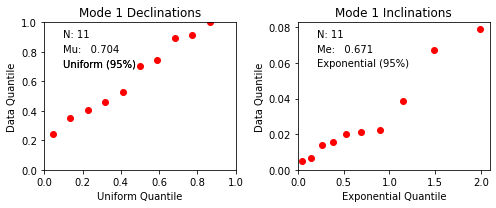

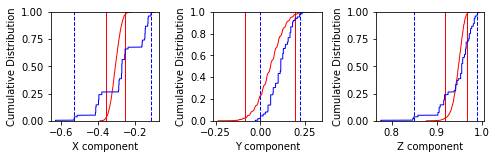

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


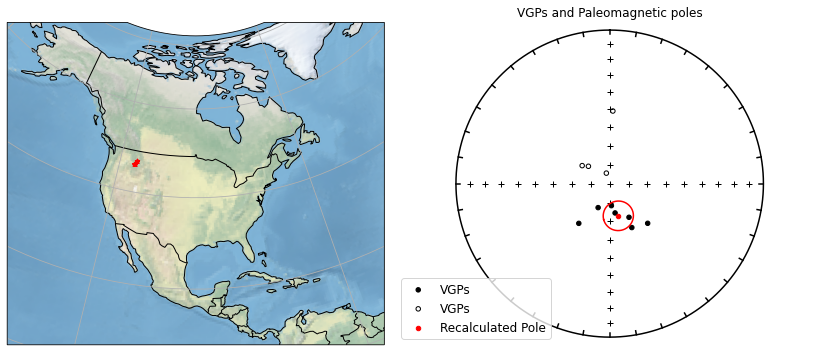

==>Analizing pole 2 (Bitterroot_Dome_intrusions).
                       Pole       N        Plat      Plon     A95
Reported paleopole     2.0        8        nan       nan      nan
Recomputed paleopole   2.0        8        68.1     279.2    27.5

 - Not enough sites to conduct quantile-quantile test


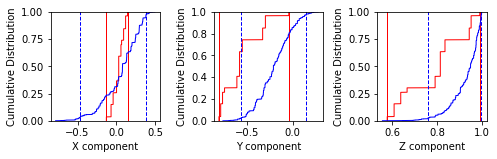

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


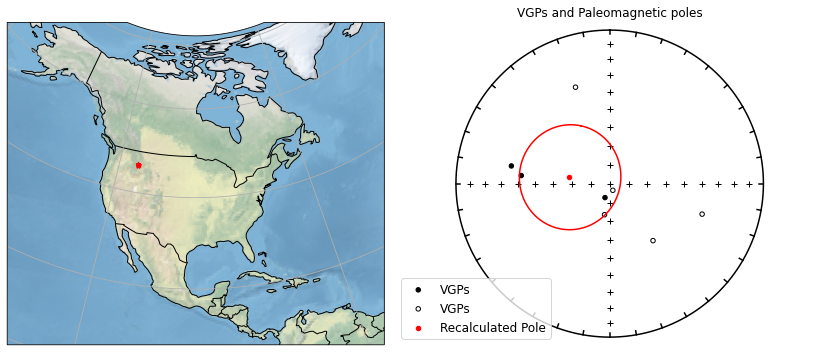


========================= NEW POLE : Central_Mexico_Plio-Pleistocene (5) =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) [18.0]

 => Coherent dec/inc in sites ('name'): [2.0, 3.0, 4.0, 6.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 17.0, 19.0, 20.0]

==>Analizing pole 1 (Central_Mexico_Plio-Pleistocene).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        13      -88.8     149.5     5.3
Recomputed paleopole   1.0        13       88.5     331.9     5.3



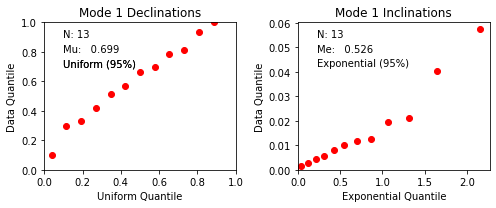

 
 - Not enough sites from one (or both) polarity populations to conduct reversal test
Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


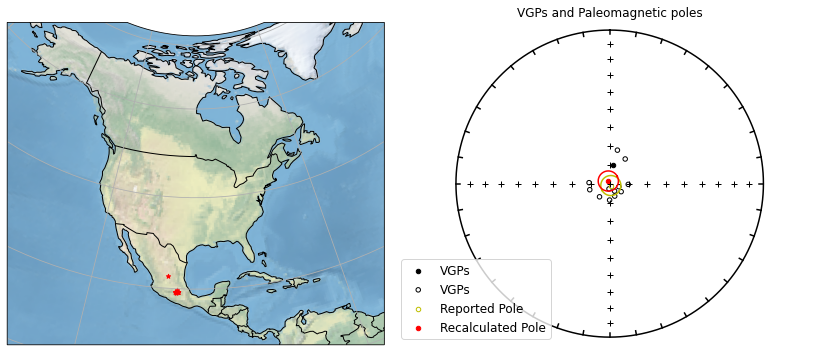


========================= NEW POLE : Clear_Lake_volcanic_field (6) =======================
==>Analizing pole 1 (Clear_Lake_volcanic_field).
 DEBUG POLE (index): 6, in_situ_pole: 1

========================= NEW POLE : Coso_Range_volcanics (7) =======================
==>Analizing pole 1 (Coso_Range_volcanics).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        2        nan       nan      nan
Recomputed paleopole   1.0        2        73.8      69.3    66.8

 - Not enough sites to conduct quantile-quantile test
 
 - Not enough sites from one (or both) polarity populations to conduct reversal test
Bayesian reversal test (Heslop & Roberts, 2018) indicates: Different means: positive support


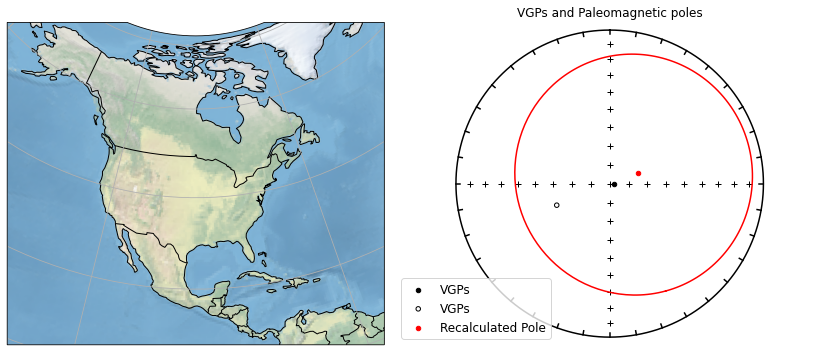


========================= NEW POLE : Dinan_Bay_lavas (8) =======================
 => Coherent dec/inc in sites ('name'): [46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0]

==>Analizing pole 1 (Dinan_Bay_lavas).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        13       83.3     137.8     9.8
Recomputed paleopole   1.0        13       83.3     144.3     9.8



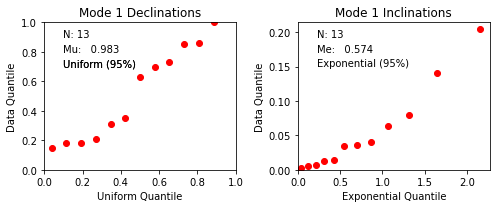

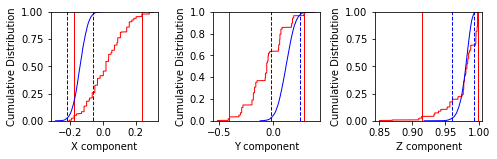

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


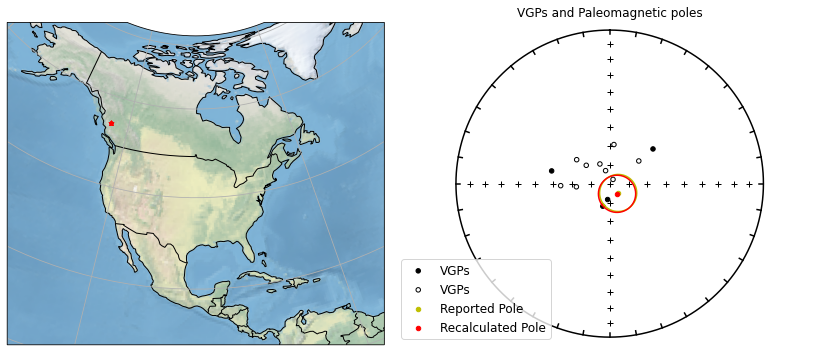


========================= NEW POLE : Eastern_Alkaline_Province (9) =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) ['VE18', 'VE11', 'VE17']

 => Coherent dec/inc in sites ('name'): ['VE19', 'VE10', 'VE13', 'VE12', 'VE09', 'VE14', 'VE16', 'VE05', 'VE03', 'VE02', 'VE04', 'VE07', 'VE01', 'VE06', 'VE15', 'VE08']

==>Analizing pole 1 (Eastern_Alkaline_Province).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        17       nan       nan      nan
Recomputed paleopole   1.0        17       89.2      78.6     5.7



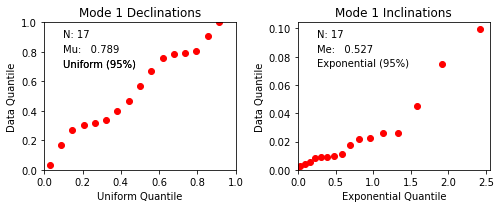

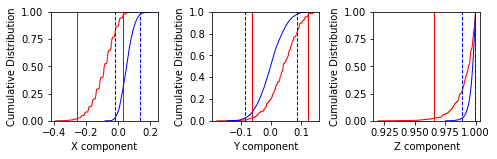

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


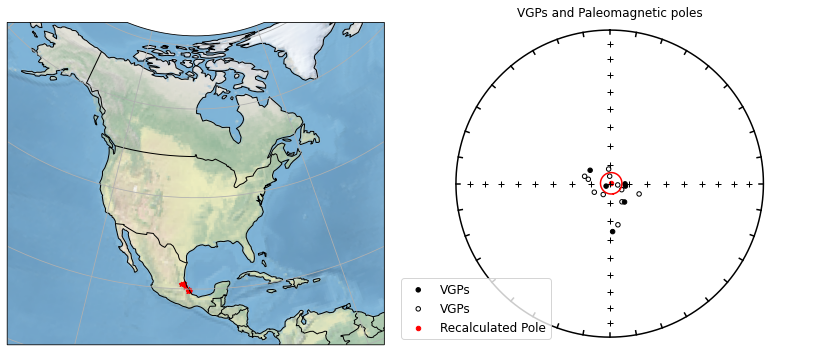


========================= NEW POLE : Eastern_TMVB (10) =======================
 => Coherent dec/inc in sites ('name'): ['SM1', 'SM2*', 'SM3', 'SM4', 'SM5', 'SM6*', 'SM7', 'SM8', 'SM9*', 'SM10*', 'SM11', 'SM12*', 'SM13', 'SM14', 'SM15', 'SM16', 'SM17', 'PS2 (VE34)', 'PS3* (VE71b)', 'PS4 (VE15)', 'PS1 (VE108)', 'CA2', 'MC2', 'MM1', 'XO1 (VE118)', 'CY1 (VE118)', 'MI1 (VE118)', 'MR1* (VE118)', 'JA1 (PH113)', 'TRT (TH24)', 'MO1 (PH171)', 'MZ1 (PH135)', 'ZC1 (PH141)', 'MS2-3 (VE94)', 'ZC2', 'SB1', 'ZC3', 'PL1 (PH62)', 'AT1 (PH40)']

==>Analizing pole 1 (Eastern_TMVB).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        12       86.8      96.8     6.5
Recomputed paleopole   1.0        12       86.3     116.9     6.8



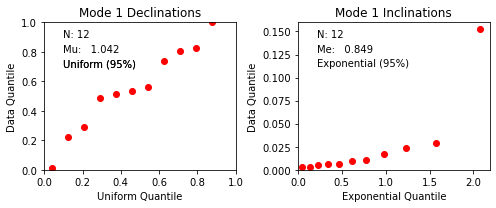

 
 - Not enough sites from one (or both) polarity populations to conduct reversal test
Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


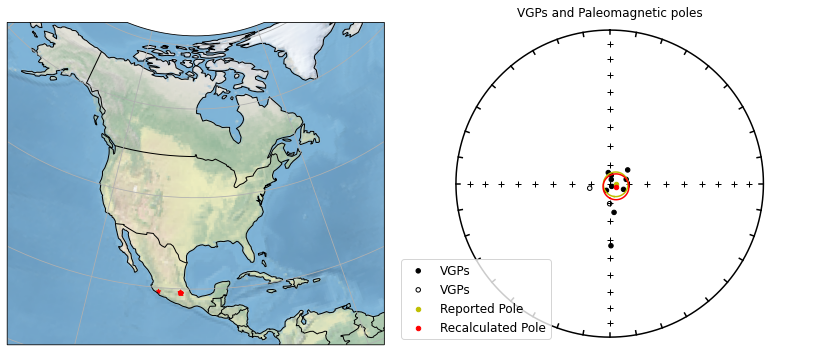

==>Analizing pole 2 (Eastern_TMVB).
                       Pole       N        Plat      Plon     A95
Reported paleopole     2.0        3        82.1     190.7    18.0
Recomputed paleopole   2.0        3        82.5     180.8    14.3

 - Not enough sites to conduct quantile-quantile test
 
 - Not enough sites from one (or both) polarity populations to conduct reversal test
Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


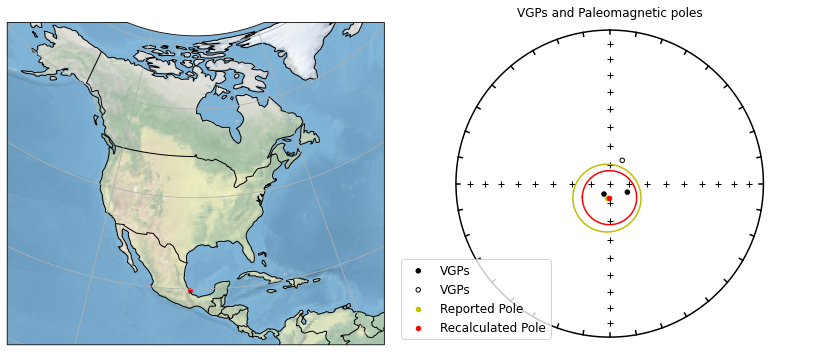

==>Analizing pole 3 (Eastern_TMVB).
                       Pole       N        Plat      Plon     A95
Reported paleopole     3.0        17       80.5     188.1     8.1
Recomputed paleopole   3.0        17       79.8     186.2     8.5



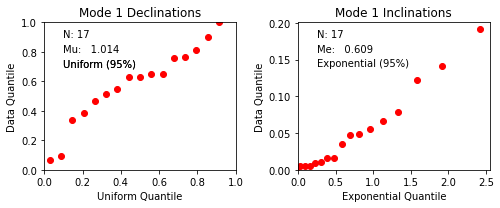

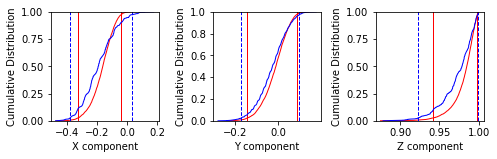

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


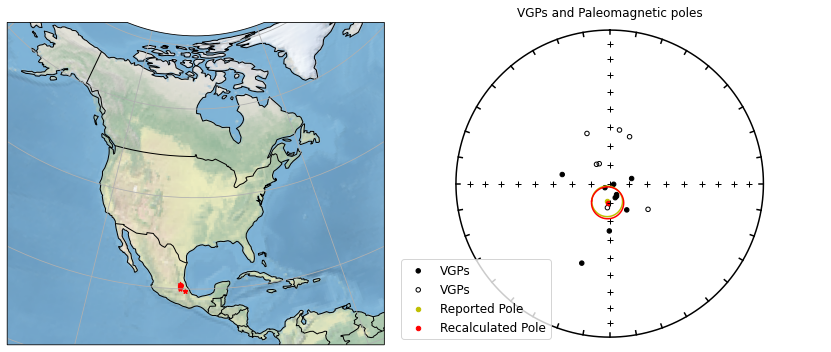


========================= NEW POLE : East_Fork_Basin_sediments (11) =======================

========================= NEW POLE : Latir_volcanic_field (12) =======================
==>Analizing pole 1 (Latir_volcanic_field).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        48       nan       nan      nan
Recomputed paleopole   1.0        48       76.3     185.4     9.4



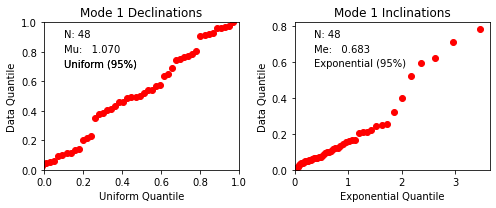

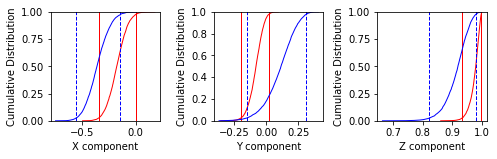

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


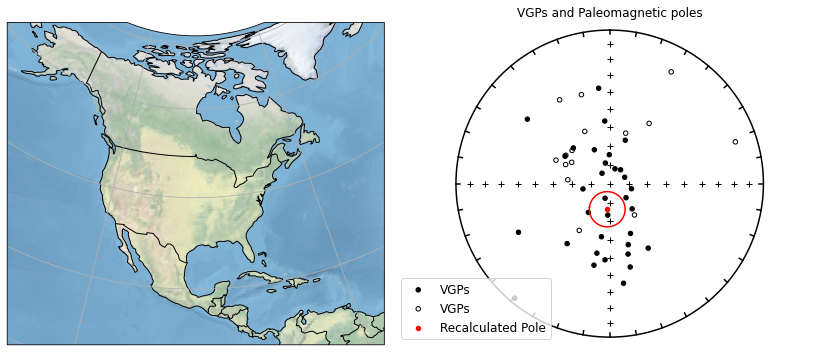

==>Analizing pole 2 (Latir_volcanic_field).
                       Pole       N        Plat      Plon     A95
Reported paleopole     2.0        43       nan       nan      nan
Recomputed paleopole   2.0        43       82.4     163.1     6.9



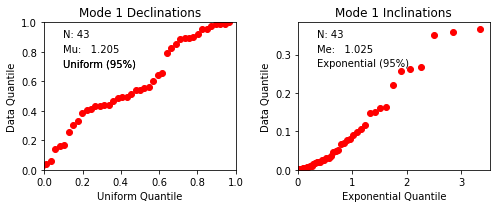

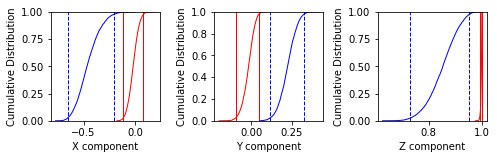

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Different means: very strong support


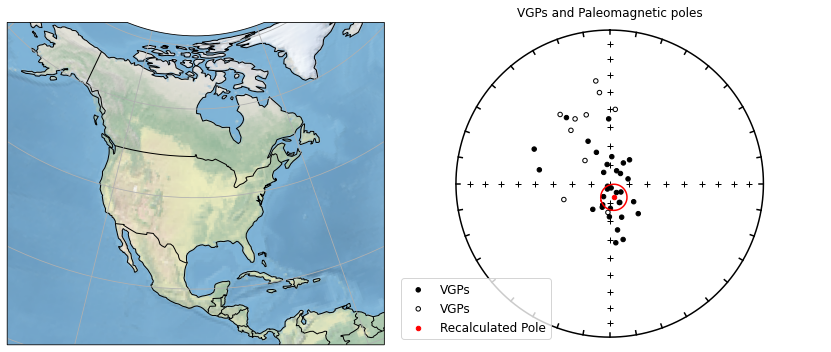


========================= NEW POLE : Long_Valley_Caldera_volcanics (13) =======================
==>Analizing pole 1 (Long_Valley_Caldera_volcanics).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        20       nan       nan      nan
Recomputed paleopole   1.0        20       87.7     191.1     7.5



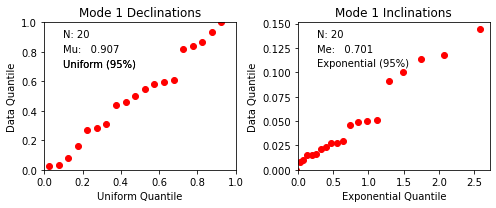

 
 - Only one polarity; cannot conduct Bootstrapped reversal test
Single Polarity, cannot conduct Bayesian Reversal Test


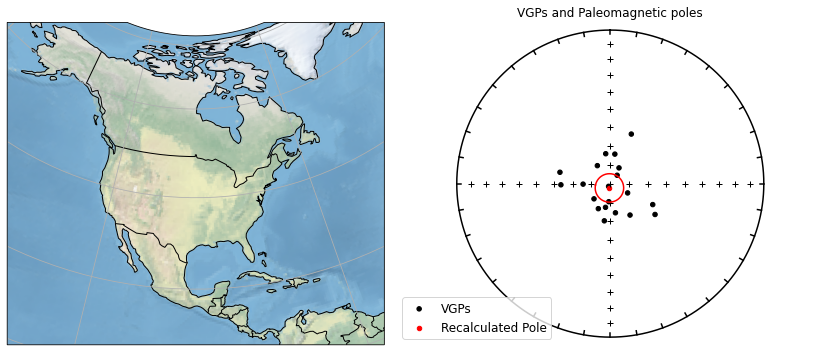


========================= NEW POLE : Mariscal_Mtn_intrusions (14) =======================
 => Coherent dec/inc in sites ('name'): ['mm8', 'mm9', 'mm10', 'mm12', 'mm13', 'mm18', 'mm19*', 'mm20', 'mm21', 'mm22*', 'mm23', 'mm24', 'mm25', 'mm26', 'mm30', 'mm31', 'mm37', 'mm39', 'mm42a', 'mm42b*', 'mm44']

==>Analizing pole 1 (Mariscal_Mtn_intrusions).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        18       80.0     185.3     5.4
Recomputed paleopole   1.0        18       80.0     185.2     5.4



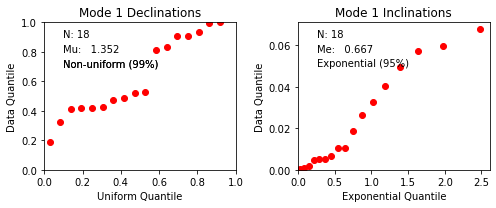

 
 - Only one polarity; cannot conduct Bootstrapped reversal test
Single Polarity, cannot conduct Bayesian Reversal Test


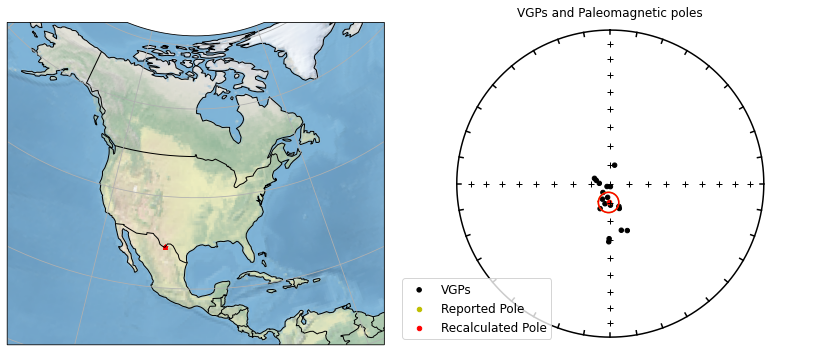


========================= NEW POLE : Michoacan_Guanajuato_volcanic_field (15) =======================
 => Coherent dec/inc in sites ('name'): ['Tan1 (TV)', 'Tan2 (TV)', 'Tan3 (UR-4)', 'Tan5 (Tan28)', 'Tan6 (Tan26)', 'Tan7 (Tan10)', 'Tan8 (Tan43)', 'Tan9 (Tan 43)', 'Tan10 (NI 19)', 'Tan11 (NI 18)']

==>Analizing pole 1 (Michoacan_Guanajuato_volcanic_field).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        8        84.4     219.9     8.5
Recomputed paleopole   1.0        8        83.1     222.7    10.1

 - Not enough sites to conduct quantile-quantile test
 
 - Only one polarity; cannot conduct Bootstrapped reversal test
Single Polarity, cannot conduct Bayesian Reversal Test


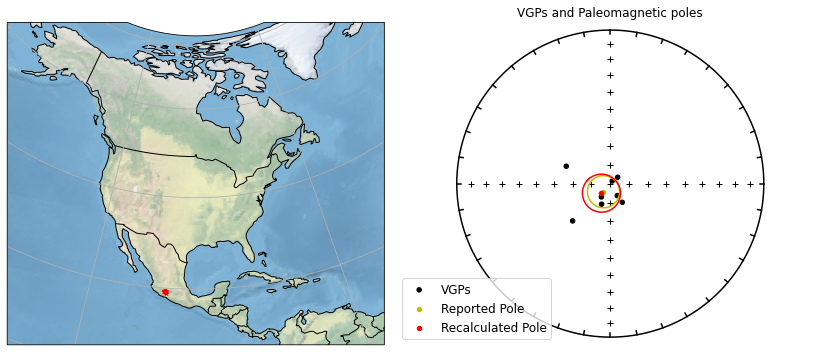


========================= NEW POLE : Mistastin_Lake_impact (16) =======================
 => Coherent dec/inc in sites ('name'): [1.0, 2.0, 3.0, '4_adj', '5_adj', 6.0, '7_adj', 8.0, 9.0, 10.0, 12.0, 1.0, 2.0, 3.0, 4.0, 5.0, 11.0, 10.0, 9.0, 6.0, '6-ani', 7.0, '7-ani', 13.0, 14.0, 15.0, 17.0]

==>Analizing pole 1 (Mistastin_Lake_impact).
 DEBUG POLE (index): 16, in_situ_pole: 1
==>Analizing pole 2 (Mistastin_Lake_impact).
 DEBUG POLE (index): 16, in_situ_pole: 2

========================= NEW POLE : Mogollon-Datil_volcanics (17) =======================
 => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) [6.0]

 => inverted vgp from sites ('name'): [1.0, 2.0, 3.0, 30.0, 31.0, 32.0, '21#', 22.0, 23.0, 62.0, 63.0, 66.0, 67.0, 75.0, 77.0, '80#', '81#', 7.0, '8', '38', '11', 47.0, 12.0, 53.0, '90', '14', '15', '16', '17', '82', '83', '18', '61', '26', '34', '39', '35', '36', '37', '40', '45', '43', '50', '51', '52', '55', '56', '71', '57', '59', '91', '94', '79

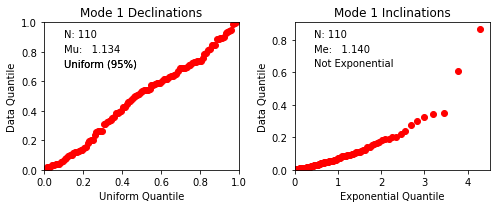

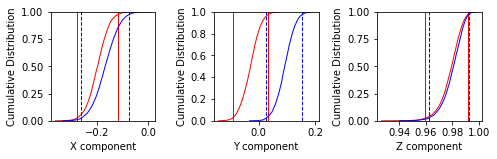

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


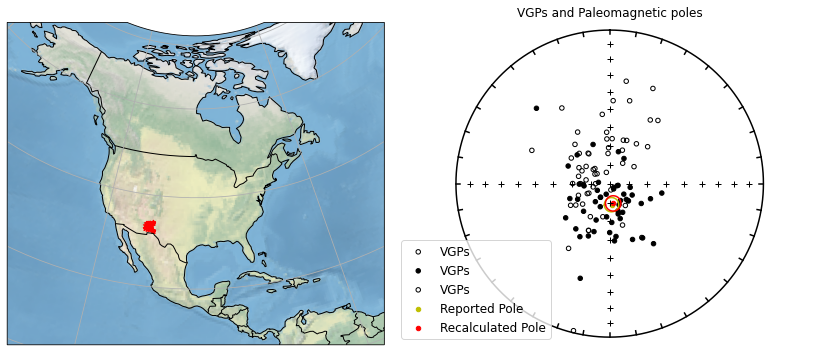


========================= NEW POLE : Monterey_intrusions (18) =======================
 => Coherent dec/inc in sites ('name'): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]

==>Analizing pole 1 (Monterey_intrusions).
                       Pole       N        Plat      Plon     A95
Reported paleopole     1.0        6        nan       nan      nan
Recomputed paleopole   1.0        6        82.6     235.6    10.2

 - Not enough sites to conduct quantile-quantile test
 
 - Only one polarity; cannot conduct Bootstrapped reversal test
Single Polarity, cannot conduct Bayesian Reversal Test


In [ ]:
for index in range(len(df_files) -1):
    print(f'')
    print(f'========================= NEW POLE : {df_files.name_xlsx[index]} ({index}) =======================')
    df = pd.read_excel(df_files['path'][index]) #, skip_blank_lines=True
    df_poles = pd.read_excel(df_files['path'][index], 
                             skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,
                             nrows  = df[df.isnull().all(1)].index[1] -3)

    df_vgps = pd.read_excel(df_files['path'][index], 
                            skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)

    #cast columns
    df_vgps = df_vgps.astype({'in_study_pole': int,
                              "slat": float, "slon": float, "dec": float, "inc": float,
                              "VGP_lat": float, "VGP_lon": float
                             })
    df_poles = df_poles.astype({'N': int,
                              "slat": float, "slon": float, "dec": float, "inc": float,
                              "Plat": float, "Plon": float})
    if df_vgps.empty: continue
    
    # redundant, but plain to see.
    df_vgps['VGP_lon'] = df_vgps['VGP_lon']
    df_vgps['VGP_lat'] = df_vgps['VGP_lat']
    
    df_vgps['VGP_lon'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0] if (np.isnan(row.VGP_lon) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lon, axis =1) 
    df_vgps['VGP_lat'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1] if (np.isnan(row.VGP_lat) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lat, axis =1) 
    
    df_vgps['VGP_lon_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1) 
    df_vgps['VGP_lat_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)
    
    df_vgps['GCD_vgps'] = df_vgps.apply(lambda row: GCD_cartesian(spherical2cartesian([np.radians(row.VGP_lat), np.radians(row.VGP_lon)]), spherical2cartesian([np.radians(row.VGP_lat_recalc), np.radians(row.VGP_lon_recalc)])), axis=1)

    # False if Spurious, True if correct, nan if inverted
    df_vgps['coherent_vgps'] = df_vgps.apply(lambda row: 'spurious' if (row.GCD_vgps > np.radians(4) and row.GCD_vgps < np.radians(176)) else ('coherent' if row.GCD_vgps < np.radians(4) else 'inverted' if row.GCD_vgps > np.radians(176) else np.nan ), axis =1) #True if it is ok, nan
    
    if not df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) &
               (df_vgps['dec'].isna() | df_vgps['inc'].isna()) &
               (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:
                  
    # if (((df_vgps['slat'].isna() | df_vgps['slon'].isna()) & (df_vgps['dec'].isna() | df_vgps['inc'].isna())).any()):
    #     index = df_vgps['slat'].index[df_vgps['slat'].apply(np.isnan)]
        print (f" => Missing slat/slon and/or dec/inc from sites ('name'): {df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) & (df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].name.tolist()} where no vgp is reported; cannot calculate vgp")
        print (f"")

    if not df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) &
                   (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:

    #if (((df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())).any()):
        print(f" => Missing dec/inc and/or vgp in sites: {df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) & (df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].name.tolist()} where no site coordinates are reported; cannot calculate site locations")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'spurious'].empty:
        print (f" => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) {df_vgps[df_vgps['coherent_vgps'] == 'spurious'].name.tolist()}")
        print (f"")
    # spourious = df_vgps[df_vgps['coherent_vgps'] == False]['name'].unique()
    # if len(spourious) != 0: 

    if not df_vgps[df_vgps['coherent_vgps'] == 'inverted'].empty:
        print (f" => inverted vgp from sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'inverted'].name.tolist()}")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'coherent'].empty:
        print (f" => Coherent dec/inc in sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'coherent'].name.tolist()}")
        print (f"")
    
    #Groupby iterates through DFs (i) 'grouped by' the variable of interest 
    for value, i in df_vgps.groupby(df_vgps['in_study_pole']): 
        # value represent the index and i represent the DF grouped by the variable of interest  
        if value != 0: #discards vgps discarded by authors

            print(f"==>Analizing pole {value} ({df_files.name_xlsx[index]}).")
            try:

               # Pick those sites where the reported vgps were inverted in order to perform a Reversal test
                df_tmp = pd.DataFrame()            
                df_tmp['vgp_lat4reversal'] = np.where(((i['coherent_vgps'] == 'inverted') & 
                                                       (~i['coherent_vgps'].isna())), 
                                                        i['VGP_lat_recalc'], i['VGP_lat'])            
                df_tmp['vgp_lon4reversal'] = np.where(((i['coherent_vgps'] == 'inverted') & 
                                                       (~i['coherent_vgps'].isna())), 
                                                        i['VGP_lon_recalc'], i['VGP_lon'])

                #split vgp population into different polarities by comparison against principal component axis             
                vgp_block = list(zip(df_tmp['vgp_lon4reversal'].tolist(), df_tmp['vgp_lat4reversal'].tolist()))            
                mode1, mode2 = pmag.separate_directions(di_block=vgp_block)

                #invert one polarity population and merge populations
                merged = invert_polarity(mode1, mode2)

                #calculate Fisher mean of merged data
                vgp_mean = ipmag.fisher_mean(di_block=merged)

                #Reported pole
                pole = df_poles[df_poles['pole'] == value]

                print_pole_statistics(pole, vgp_mean)

                # Test whether a distribution is Fisherian
                test_fishqq(merged)

                #reversal test            
                reversal_test(mode1, mode2)

                #Bayesian reversal Test
                P = bayes_probability_heslop(mode1, mode2)
                if P != 9999: print(f"Bayesian reversal test (Heslop & Roberts, 2018) indicates: {bayes_support(P)}")

                # Plot sites and directions
                Plot_VgpsAndSites(i, pole, vgp_mean, mode1, mode2)      

            except: #could be expanded!
                print(f" DEBUG POLE (index): {index}, in_situ_pole: {value}")